In [49]:

import pip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

data prep

In [2]:
df_04 = pd.read_stata('usu_individual_T104.dta')
df_24 = pd.read_excel('usu_individual_T124.xlsx')

t_df_04 = df_04[df_04['region'] == 'Patagónica']
t_df_24 = df_24[df_24['REGION'] == 44] 

t_df_04.columns = t_df_04.columns.str.upper()
t_df_24.columns = t_df_24.columns.str.upper()


df_merged = pd.concat([t_df_04, t_df_24])

df_merged['REGION'] = df_merged['REGION'].replace({44: 'Patagónica'})
df_merged['ESTADO'] = df_merged['ESTADO'].replace({1: 'Ocupado', 2: 'Desocupado', 3: 'Inactivo', 4: 'Menor de 10 años'})
df_merged['CH04'] = df_merged['CH04'].replace({1: 'Varón', 2: 'Mujer'})
df_merged['CH12'] = df_merged['CH12'].replace({1: 'Jardín/Preescolar', 2: 'Primario', 3: 'EGB', 4: 'Secundario', 5:'Polimodal', 6:'Terciario', 7:'Universitario', 8:'Posgrado Universitario', 9:'Educación especial (discapacitado)'})
df_merged['CH13'] = df_merged['CH13'].replace({1: 'Sí', 2: 'No'})
df_merged['CH14'] = df_merged['CH14'].str.strip()
df_merged['CH14'] = pd.to_numeric(df_merged['CH14'], errors='coerce')

df_merged

,CODUSU,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,...,ADECCFR,PJ1_1,PJ2_1,PJ3_1,IDIMPP,CH05,IMPUTA,PONDIIO,PONDII,PONDIH
42025,125122,1.0,1.0,Sí,2004.0,1er. Trimestre,Patagónica,N,Comodoro Rivadavia - Rada Tilly,150.0,...,09,0.0,0.0,0.0,00000,NaN,NaN,NaN,NaN,NaN
42026,125969,1.0,1.0,Sí,2004.0,1er. Trimestre,Patagónica,N,Comodoro Rivadavia - Rada Tilly,120.0,...,07,0.0,0.0,0.0,00000,NaN,NaN,NaN,NaN,NaN
42027,125969,1.0,2.0,Sí,2004.0,1er. Trimestre,Patagónica,N,Comodoro Rivadavia - Rada Tilly,120.0,...,07,0.0,0.0,0.0,00000,NaN,NaN,NaN,NaN,NaN
42028,126757,1.0,1.0,Sí,2004.0,1er. Trimestre,Patagónica,N,Comodoro Rivadavia - Rada Tilly,223.0,...,04,0.0,0.0,0.0,00000,NaN,NaN,NaN,NaN,NaN
42029,126757,1.0,2.0,Sí,2004.0,1er. Trimestre,Patagónica,N,Comodoro Rivadavia - Rada Tilly,223.0,...,04,0.0,0.0,0.0,00000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46028,TQRMNOQWXHJMKOCDEOHCH00803080,1.0,1,1,2024.0,1,Patagónica,N,91,128.0,...,7,NaN,NaN,NaN,NaN,1988-03-29 00:00:00,NaN,130.0,129.0,126.0
46029,TQRMNOQWXHJMKOCDEOHCH00803080,1.0,2,1,2024.0,1,Patagónica,N,91,128.0,...,7,NaN,NaN,NaN,NaN,2010-03-10 00:00:00,NaN,128.0,128.0,126.0
46030,TQRMNOQWXHJMKOCDEOHCH00803080,1.0,3,1,2024.0,1,Patagónica,N,91,128.0,...,7,NaN,NaN,NaN,NaN,2012-12-01 00:00:00,NaN,128.0,128.0,126.0
46031,TQRMNOQXQHJMKOCDEOHCH00794205,1.0,1,1,2024.0,1,Patagónica,N,91,131.0,...,4,NaN,NaN,NaN,NaN,1995-03-03 00:00:00,NaN,133.0,133.0,135.0


In [3]:
def calculate_years_of_education(row):
    
    years = 0
    
    
    level = row['CH12']
    completed = row['CH13']
    last_year = row['CH14']
    
    
    if pd.isna(level) or level == 0.0:
        return 0
    
   
    if isinstance(level, (int, float)):
        level = str(level)
    
    
    if level == 'Jardín/Preescolar' or level == '1':
       
        years = 0
        if completed == 'Sí' or completed == '1':
            years = 0  
    
    elif level == 'Primario' or level == '2':
        
        if completed == 'Sí' or completed == '1':
            years = 7
        else:
            
            years = min(int(last_year), 7) if not pd.isna(last_year) and last_year not in [98, 99] else 0
    
    elif level == 'EGB' or level == '3':
        
        if completed == 'Sí' or completed == '1':
            years = 9
        else:
            
            years = min(int(last_year), 9) if not pd.isna(last_year) and last_year not in [98, 99] else 0
    
    elif level == 'Secundario' or level == '4':
        
        if completed == 'Sí' or completed == '1':
            years = 12
        else:
            
            years = 7 + min(int(last_year), 5) if not pd.isna(last_year) and last_year not in [98, 99] else 7
    
    elif level == 'Polimodal' or level == '5':
        
        if completed == 'Sí' or completed == '1':
            years = 12
        else:
            
            last_polimodal = int(last_year) if not pd.isna(last_year) and last_year not in [98, 99] else 0
            years = 9 + min(last_polimodal, 3)
    
    elif level == 'Terciario' or level == '6':
        
        if completed == 'Sí' or completed == '1':
            years = 15 
        else:
           
            tertiary_years = int(last_year) if not pd.isna(last_year) and last_year not in [98, 99] else 0
            years = 12 + min(tertiary_years, 3)
    
    elif level == 'Universitario' or level == '7':
       
        if completed == 'Sí' or completed == '1':
            years = 17  
        else:
            
            university_years = int(last_year) if not pd.isna(last_year) and last_year not in [98, 99] else 0
            years = 12 + min(university_years, 5)
    
    elif level == 'Posgrado Universitario' or level == '8':
       
        if completed == 'Sí' or completed == '1':
            years = 19  
        else:
            
            postgrad_years = int(last_year) if not pd.isna(last_year) and last_year not in [98, 99] else 0
            years = 17 + min(postgrad_years, 2)
    
    elif level == 'Educación especial (discapacitado)' or level == '9':
        
        years = int(last_year) if not pd.isna(last_year) and last_year not in [98, 99] else 0
    
    return years

In [7]:

df_merged = df_merged[df_merged['CH06'] != 'Menos de 1 año']
df_merged = df_merged[df_merged['CH06'] != '98 y más años']

df_merged['CH06'].astype(float)
df_merged['edad2'] = df_merged['CH06'].apply(lambda x: x**2)
df_merged['edad'] = df_merged['CH06']

df_merged['salario_semanal'] = df_merged['P21'] / 40

df_merged['educ'] = df_merged.apply(calculate_years_of_education, axis=1)

df_merged['mujer'] = (df_merged['CH04'] == 'Mujer').astype(int)

base = df_merged[['edad','edad2', 'salario_semanal', 'educ', 'mujer','ANO4','ESTADO']]

A 1

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


diferencias_por_anio = {}


anios = base['ANO4'].unique()

for anio in anios:
    
    datos_anio = base[base['ANO4'] == anio].copy()
    
   
    datos_anio['desocupado'] = (datos_anio['ESTADO'] == 'Desocupado').astype(int)
    
    
    y = datos_anio['desocupado']
    
    
    X = datos_anio[['edad', 'edad2', 'salario_semanal', 'educ', 'mujer']].copy()
    
    
    X['intercepto'] = 1
    
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=444)
    
    
    medias_train = X_train.mean()
    medias_test = X_test.mean()
    
    
    diferencia = medias_train - medias_test
    
    
    diferencias_por_anio[anio] = diferencia


tabla_diferencias = pd.DataFrame(diferencias_por_anio).T
print(tabla_diferencias)

            edad      edad2 salario_semanal      educ     mujer intercepto
2004.0 -0.311749    0.76724       -0.186803  0.096489  0.000371        0.0
2024.0  0.638761  68.802778      238.338336 -0.144596  0.017967        0.0


B 2 and 3

In [52]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error


datos_2024 = base[(base['ANO4'] == 2024) & (base['ESTADO'] == 'Ocupado')].copy()


y = datos_2024['salario_semanal']


X_total = datos_2024[['edad', 'edad2', 'educ', 'mujer']]


X_train, X_test, y_train, y_test = train_test_split(X_total, y, train_size=0.7, random_state=444)


modelos = {
    'i. salario_semanal ~ edad': ['edad'],
    'ii. salario_semanal ~ edad + edad2': ['edad', 'edad2'],
    'iii. salario_semanal ~ edad + edad2 + educ': ['edad', 'edad2', 'educ'],
    'iv. salario_semanal ~ edad + edad2 + educ + mujer': ['edad', 'edad2', 'educ', 'mujer'],
}


for nombre_modelo, variables in modelos.items():
    X_m = X_train[variables]
    X_m = sm.add_constant(X_m)
    modelo = sm.OLS(y_train, X_m).fit()
    
    
    y_pred = modelo.predict(X_m)

    
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, y_pred)


    print(f"\n📌 {nombre_modelo}")
    print("Coefs:")
    print(modelo.params.round(4))
    print("\nMetrics:")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
C5


🔍 Logistic Regression
Confusion Matrix:
 [[1622    0]
 [  37    0]]
AUC: 0.6800
Accuracy: 0.9777

🔍 KNN (k=5)
Confusion Matrix:
 [[1622    0]
 [  37    0]]
AUC: 0.5219
Accuracy: 0.9777


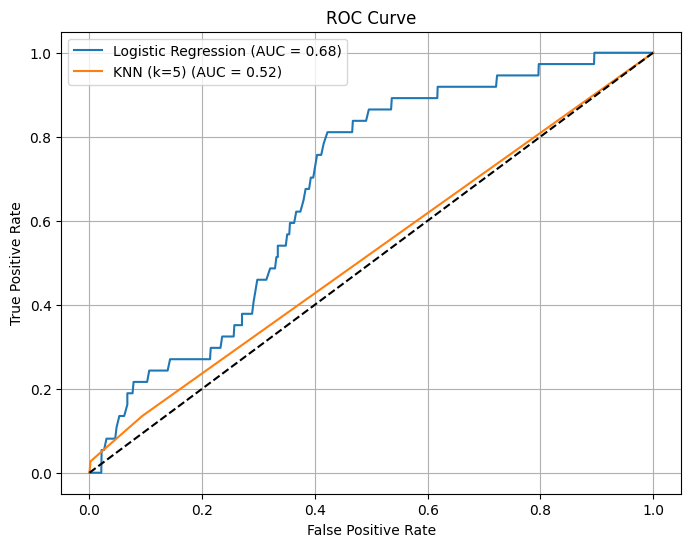

In [55]:

datos_2024 = base[base['ANO4'] == 2024].copy()
datos_2024['desocupado'] = (datos_2024['ESTADO'] == 'Desocupado').astype(int)


features = ['edad', 'edad2', 'educ', 'mujer']
X = datos_2024[features]
y = datos_2024['desocupado']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=444)


logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)



def evaluate_model(name, model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs > 0.5).astype(int)

    
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(y_test, y_pred)

    
    print(f"\n🔍 {name}")
    print("Confusion Matrix:\n", cm)
    print(f"AUC: {roc_auc:.4f}")
    print(f"Accuracy: {acc:.4f}")

    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")


plt.figure(figsize=(8, 6))
evaluate_model("Logistic Regression", logit_model, X_test, y_test)
evaluate_model("KNN (k=5)", knn_model, X_test, y_test)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

C6

In [76]:
nonrespondieron = base[base['ESTADO'] == 0]

nonrespondieron = nonrespondieron.copy()


X_noresp = nonrespondieron[features]



y_noresp_probs = logit_model.predict_proba(X_noresp)[:, 1]
y_noresp_pred = (y_noresp_probs > 0.5).astype(int)


proporcion_desocupados = y_noresp_pred.mean()
print(f"\n📌 Proportion of 'norespondieron' predicted as unemployed: {proporcion_desocupados:.2%}")


📌 Proportion of 'norespondieron' predicted as unemployed: 0.00%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=096ede0e-fb6d-4c63-ba59-d8bef62303c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>